# Learning Rate Scheduling

В данном ноутбуке мы с вами познакомимся с понятием запланированного изменения скорости обучения (learning rate scheduling), а также разберемся, как использовать это в фреймворке TensorFlow.

Давайте установим необходимые библиотеки, импортируем их и установим необходимый размер изображений в matplotlib.

In [ ]:
!pip install tensorflow seaborn matplotlib numpy

import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style("darkgrid")

Для данного ноутбука нам потребуется запустить модель на обучение, однако результаты самого обучения не будут нас интересовать, поэтому мы создадим простой набор данных и модель из единственного слоя.

In [2]:
x_data, y_data = np.arange(100).reshape(5, 20), np.zeros(5)
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_dim=20)])
EPOCHS = 10

Что такое изменение скорости обучения?

В процессе обучения нейронных сетей вы могли заметить, что в самом начале обучения ошибка очень велика и сети необходимы большие градиенты для того, чтобы достаточно быстро дойти до необходимого подпространства с относительно оптимальными решениями. Однако, чем ближе к концу обучения, тем больше хочется, чтобы learning rate был меньше, т.к. под конец обучения мы ищем наиболее оптимальную точку в текущем минимуме, для чего нам желательны небольшие шаги поиска.  

Каким образом мы можем сделать так, чтобы в начале обучения наш параметр learning rate был равен одному значению, а под конец обучения - другому? 

Для решения этой задачи в фреймворке TensorFlow присутствует модуль schedules, который позволяет настроить различные стратегии изменения параметра learning rate. Каждый из классов внутри данного модуля реализует одну из стратегий. Давайте импортируем и создадим несколько из них.

In [3]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay, PiecewiseConstantDecay, PolynomialDecay, InverseTimeDecay

schedules = [
    ExponentialDecay(initial_learning_rate=1e-2, decay_steps=1000, decay_rate=0.1),
    PiecewiseConstantDecay(boundaries=[200, 400, 600], values=[1e-2, 5e-3, 1e-3, 5e-4]),
    PolynomialDecay(initial_learning_rate=1e-2, decay_steps=1000, end_learning_rate=5e-4),
    InverseTimeDecay(initial_learning_rate=1e-2, decay_steps=1000, decay_rate=0.9)
]

Каждый из объектов обладает одинаковой сигнатурой. После создания к данному объекту можно обратиться, передав номер текущего шага обучения, и в ответ будет выдано значение learning rate для текущего этапа. Давайте построим графики этих стратегий с теми параметрами, которые были им поданы в процессе инициализации.

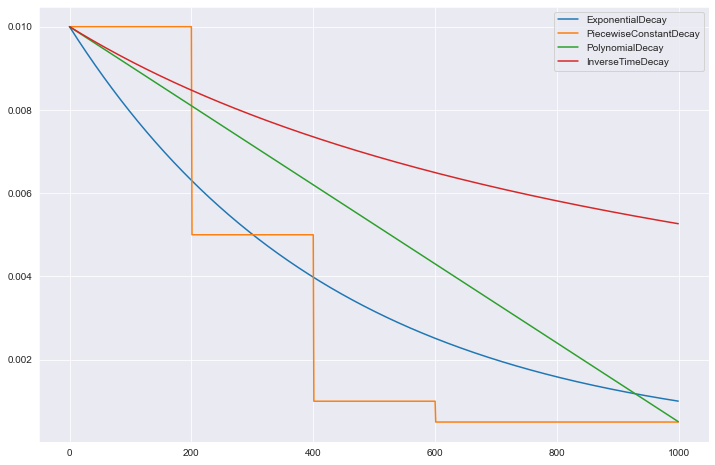

In [4]:
plt.figure()
for sch in schedules:
    plt.plot(range(1000), [sch(x) for x in range(1000)])
plt.legend(['ExponentialDecay', 'PiecewiseConstantDecay', 'PolynomialDecay', 'InverseTimeDecay'])
plt.show()

Например, PiecewiseConstantDecay реализует стратегию, которая позволяет вам задать константные значения learning rate для определенных отрезков вашего процесса обучения, а ExponentialDecay реализует стандартную экспоненциальную стратегию убывания.  

Более подробную информацию по каждой из стратегий можно найти в документации: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/

Для того, чтобы использовать данную стратегию, достаточно подать ее любому оптимизатору вместо значения learning rate:

In [5]:
sch = PolynomialDecay(initial_learning_rate=1e-2, decay_steps=1000, end_learning_rate=5e-4)

optimizer = tf.keras.optimizers.SGD(learning_rate=sch)
model.compile(optimizer, loss='mse')
history = model.fit(x_data, y_data, epochs=EPOCHS, verbose=0)

Кроме того, возможно создать собственную стратегию и использовать ее в процессе обучения. Это делается следующим образом:
1. Сначала создайте функцию, которая будет принимать номер эпохи и текущий learning rate. На основании этих данных верните из функции новое значение learning rate. К примеру, функция ниже первые несколько эпох возвращает текущий learning rate, а потом снижает его в 2 раза на каждом шаге.

In [6]:
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * 0.5

2. Далее создайте объект tf.keras.callbacks.LearningRateScheduler и в качестве аргумента передайте ему созданную вами функцию. Callback'и - это объекты, вызываемые в процессе обучения на каждом из этапов (конец эпохи, начало эпохи, начало батча, и т.д.), которые могут имплементировать различную сложную логику для выполнения в процессе обучения. В качестве примеров можно привести ранюю остановку обучения при достижении некоторых условий, логгирование процесса обучения, сохранение промежуточных весов модели, и т.д.

In [7]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

3. После этого укажите начальное значение learning_rate в оптимизаторе и в методе model.fit передайте список callback'ов с ранее созданным вами callback'ом.

In [8]:
model.compile(tf.keras.optimizers.SGD(learning_rate=0.01), loss='mse')
history = model.fit(x_data, y_data, epochs=EPOCHS, callbacks=[callback], verbose=0)

Данный callback будет вызван в конце каждой эпохи обучения. Значение learning_rate будет также сохранено в объекте history под ключом lr, поэтому мы можем его визуализировать после процесса обучения.

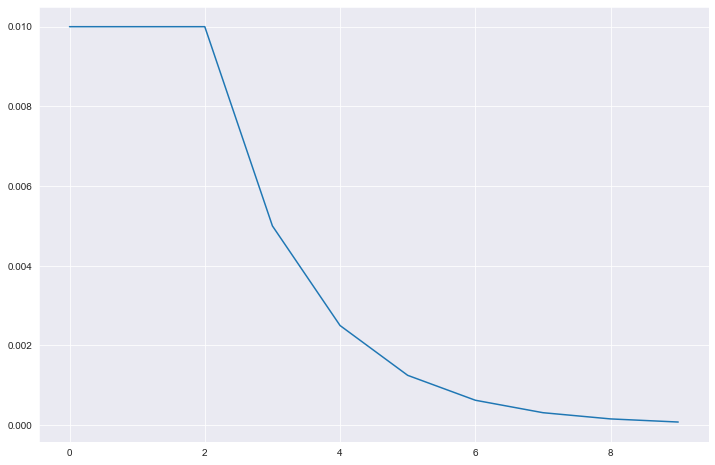

In [9]:
plt.plot(range(EPOCHS), history.history['lr'])

Данные техники помогут вам реализовать возможность изменения learning rate в процессе обучения и достичь более высоких результатов в обучении нейронных сетей.

Успехов!